# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense
from keras.initializers import glorot_uniform
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs = ROOT.RDataFrame('mutau_tree', 'mt16/data_obs.root')
file_sig = ROOT.RDataFrame('mutau_tree', {'mt16/ggH_bbtt*.root', 'mt16/vbf_bbtt*.root'})
file_ZTT = ROOT.RDataFrame('mutau_tree', 'mt16/embedded.root')
file_TT = ROOT.RDataFrame('mutau_tree', 'mt16/TT.root')

files = [file_obs, file_sig, file_ZTT, file_TT]

## Define some input features

In [3]:
# define 4-vectors, invariant masses and etc.
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
m_btt = '(mytt+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(mymu,mytau)'
dR_bmu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_btau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
m_bmu = '(mymu+myb1).M()'
m_btau = '(mytau+myb1).M()'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'


# define transverse masses mT and D_zeta
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'


# add defined variables to dataframe
for i in range(len(files)):
    files[i] = files[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('dR_tt', dR_tt)\
    .Define('m_bmu', m_bmu)\
    .Define('m_btau', m_btau)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('dR_bmu', dR_bmu)\
    .Define('dR_btau', dR_btau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [4]:
# 2016 mu+tau trigger requirements
trigger22 = '((passMu22eta2p1 && matchMu22eta2p1_1 && filterMu22eta2p1_1 && pt_1>23) or\
(passTkMu22eta2p1 && matchTkMu22eta2p1_1 && filterTkMu22eta2p1_1 && pt_1>23) or\
(passMu22 && matchMu22_1 && filterMu22_1 && pt_1>23) or\
(passTkMu22 && matchTkMu22_1 && filterTkMu22_1 && pt_1>23))'
trigger1920 = '((passMu19Tau20 && matchMu19Tau20_1 && matchMu19Tau20_2 && filterMu19Tau20_1 && filterMu19Tau20_2 && pt_1>20 && pt_1<23 && fabs(eta_2)<2.1) or\
(passMu19Tau20SingleL1 && matchMu19Tau20SingleL1_1 && matchMu19Tau20SingleL1_2 && filterMu19Tau20SingleL1_1 && filterMu19Tau20SingleL1_2 && pt_1>20 && pt_1<23 && fabs(eta_2)<2.1))'
trigger = trigger22 + str(' or ') + trigger1920


for i in range(len(files)):
    files[i] = files[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter(trigger)\
    .Filter('pt_2>25')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')\
    .Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.6321')

files[0] = files[0].Filter('Flag_eeBadScFilter==0')
files[2] = files[2].Filter('Flag_eeBadScFilter==0')

files[3] = files[3].Filter('gen_match_2!=6').Filter('gen_match_1<3 && gen_match_2<3')

files[1] = files[1].Filter('gen_match_2!=6')

files[2] = files[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# QCD region
qcd = files[0].Filter('q_1*q_2>0').Filter('byLooseDeepVSjet_2==0')

# signal region
for i in range(len(files)):
    files[i] = files[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [5]:
# list of feature variables
feature_list = ['pt_1', 'm_sv', 'm_btt', 'tt_pt', 'tt_eta', 'm_bmu', 'm_btau', 'dR_tt', 'dR_bmu', 'dR_btau', 'mT_mu', 'mT_tau', 'Dzeta',\
                'bpt_deepcsv_1', 'beta_deepcsv_1', 'met', 'njets']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(len(files)):
    files[i] = pd.DataFrame(files[i].AsNumpy(feature_list))
qcd = pd.DataFrame(qcd.AsNumpy(feature_list))

# tag MC signal events as class 1
files[1]['label'] = np.ones((files[1].shape[0], 1))

# tag MC background events as class 0
files[2]['label'] = np.zeros((files[2].shape[0], 1))
files[3]['label'] = np.zeros((files[3].shape[0], 1))
qcd['label'] = np.zeros((qcd.shape[0],1))

for i in range(len(files)):
    print(str(files[i].shape))
print(str(qcd.shape))

(63205, 17)
(34533, 18)
(90862, 18)
(3610, 18)
(123801, 18)


## Split into MC/data

In [6]:
# reduce class 0 sample size for balanced training
files[2] = files[2].sample(n = 10923, random_state = 20)
qcd = qcd.sample(n = 20000, random_state = 20)


# collect all MC as one dataframe, separated from another datafream for observed data
df_obs = files[0]
df_MC = [files[1], files[2], files[3], qcd]

df_MC = pd.concat(df_MC)


print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


Observed dataframe: 
            pt_1        m_sv       m_btt       tt_pt    tt_eta       m_bmu  \
0      30.324411   85.002357  126.666681   60.641621 -0.371219   36.435984   
1      40.052704  194.900345  256.261211   70.290839 -1.081582   96.517751   
2      85.845718  210.014465  248.378713   92.035480  1.433019  101.448560   
3      63.556763   96.917519  134.206183   54.208779 -0.850575   86.184181   
4      23.474319   97.949493  277.806277   54.987213 -1.387704  142.296264   
...          ...         ...         ...         ...       ...         ...   
63200  34.858189   57.864571  171.149539  167.039701 -0.698483   63.655058   
63201  27.958717   76.257668  216.473732   32.266113 -2.160468  100.614616   
63202  41.150219  145.261475  240.988590   33.126420 -2.624251  149.844793   
63203  52.925243  263.970490  552.784058   59.631297 -1.377070  449.924262   
63204  53.423828   98.772026  194.566780   78.636683 -0.195110  100.968869   

           m_btau     dR_tt    dR_bmu   d

## Compare input feature distributions between sig and bkg

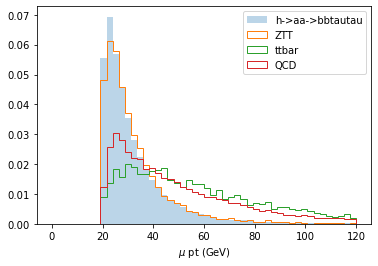

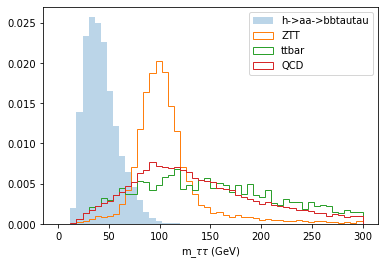

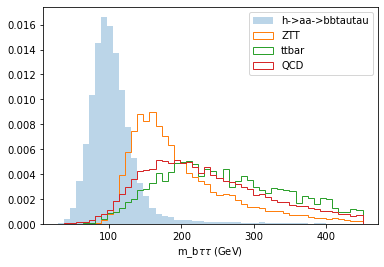

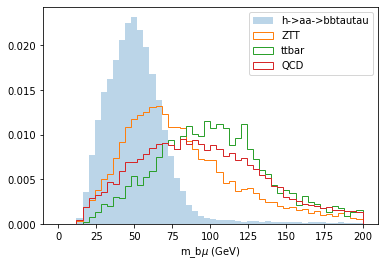

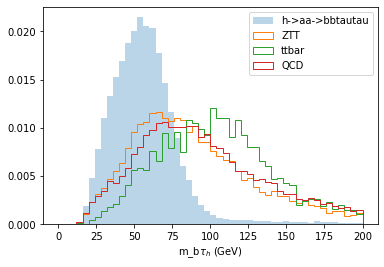

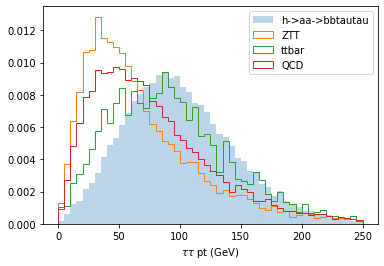

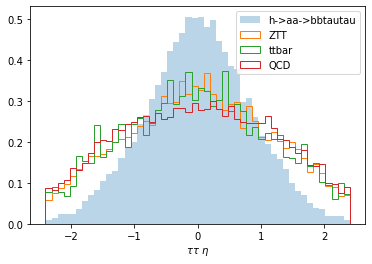

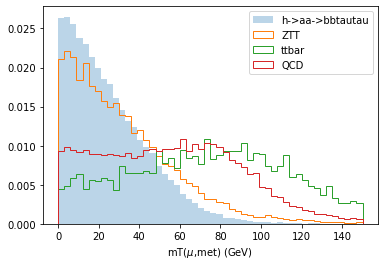

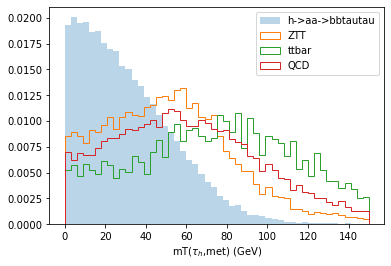

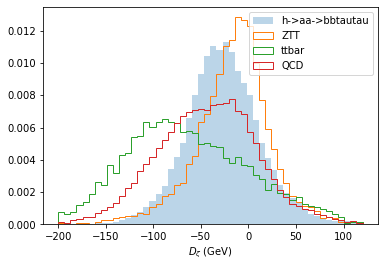

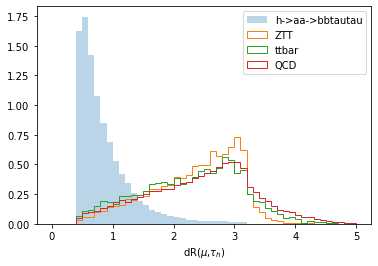

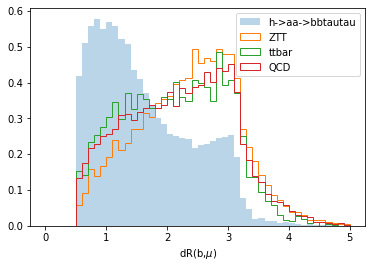

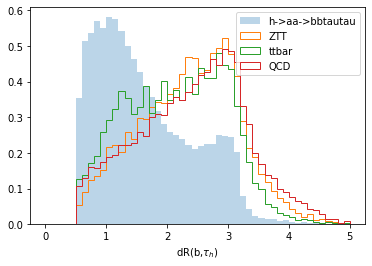

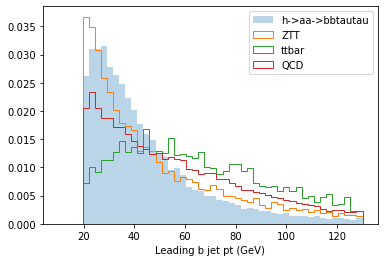

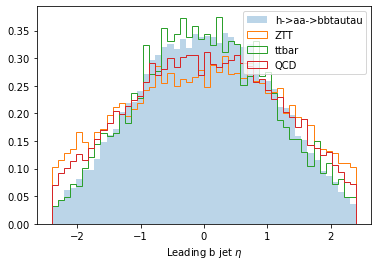

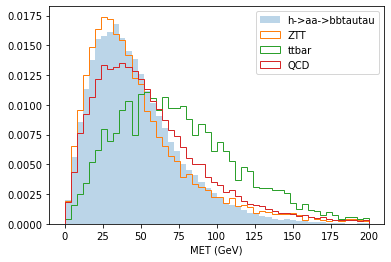

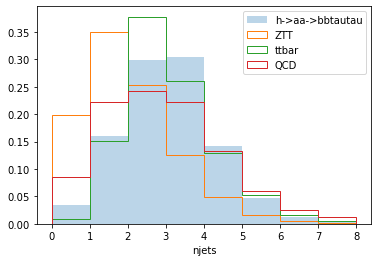

In [7]:
pyplot.hist(files[1]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_sv'], density = 1, range = (0,300), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['m_sv'], density = 1, range = (0,300), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_sv'], density = 1, range = (0,300), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_sv'], density = 1, range = (0,300), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['m_sv'], density = 1, range = (0,300), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bmu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['m_bmu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bmu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bmu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['m_bmu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\mu$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_btau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['m_btau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_btau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_btau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['m_btau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
#pyplot.hist(files[0]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()

pyplot.hist(files[1]['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['mT_mu'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['mT_tau'], density = 1, range = (0,150), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['dR_bmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['dR_btau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['beta_deepcsv_1'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet $\eta$')
pyplot.show()

pyplot.hist(files[1]['met'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('MET (GeV)')
pyplot.show()

pyplot.hist(files[1]['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'QCD', histtype = 'step')
#pyplot.hist(files[0]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'data_obs', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()


## Input data pre-processing

In [8]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

dataset_obs = df_obs.values
X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

#dataset_DY = df_DY.values
#X_DY = dataset_DY[:,0:(dataset_DY.shape[1])]


# give train/val/test partition ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_obs = scaler.transform(X_obs)
#X_DY = scaler.transform(X_DY)


# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.80/0.10/0.10
X_train.shape: (55252, 17)
Y_train.shape: (55252, 1)
X_val.shape: (6907, 17)
Y_val.shape: (6907, 1)
X_test.shape: (6907, 17)
Y_test.shape: (6907, 1)

X_obs.shape: (63205, 17)

Total number of sig/bkg examples: 34533/34533 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 27651/27601 (50.0%/50.0%)
val   : 3446/3461 (49.9%/50.1%)
test  : 3436/3471 (49.7%/50.3%)


## Neural network achitecture

In [9]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')


######## hidden layers ########
hidden_1 = Dense(
    units = 20,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

hidden_2 = Dense(
    units = 20,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(hidden_1)


######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(hidden_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 17)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 20)                360       
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 20)                420       
_________________________________________________________________
Y_output (Dense)             (None, 1)                 21        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


2021-01-16 22:13:18.539455: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-01-16 22:13:18.540156: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Model training

In [10]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 40,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 55252 samples, validate on 6907 samples
Epoch 1/40
55252/55252 [==============================] - 1s 23us/step - loss: 0.3121 - accuracy: 0.8654 - val_loss: 0.1551 - val_accuracy: 0.9421
Epoch 2/40
55252/55252 [==============================] - 1s 14us/step - loss: 0.1421 - accuracy: 0.9456 - val_loss: 0.1295 - val_accuracy: 0.9527
Epoch 3/40
55252/55252 [==============================] - 1s 13us/step - loss: 0.1247 - accuracy: 0.9534 - val_loss: 0.1196 - val_accuracy: 0.9570
Epoch 4/40
55252/55252 [==============================] - 1s 13us/step - loss: 0.1162 - accuracy: 0.9573 - val_loss: 0.1161 - val_accuracy: 0.9567
Epoch 5/40
55252/55252 [==============================] - 1s 12us/step - loss: 0.1117 - accuracy: 0.9589 - val_loss: 0.1094 - val_accuracy: 0.9582
Epoch 6/40
55252/55252 [==============================] - 1s 13us/step - loss: 0.1088 - accuracy: 0.9596 - val_loss: 0.1079 - val_accuracy: 0.9580
Epoch 7/40
55252/55252 [==============================] - 1s 13us/ste

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

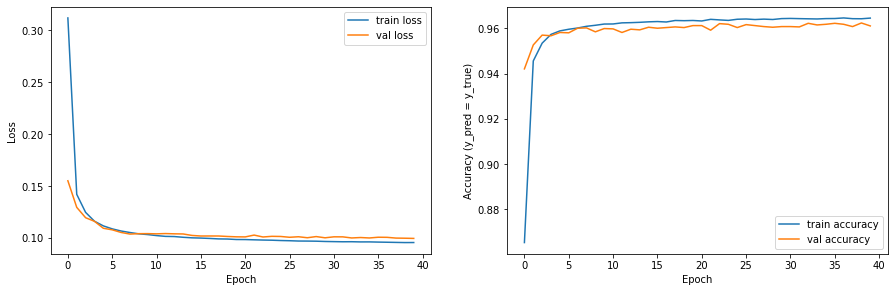

In [11]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [12]:
# count sig/bkg examples in the test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

## Test set performance plots

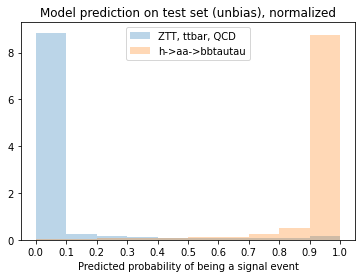

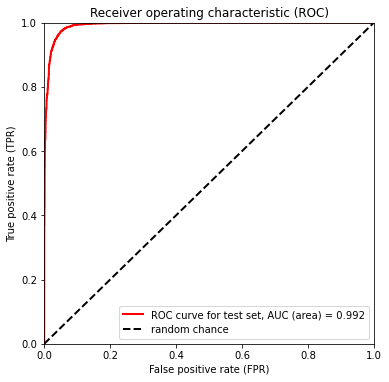

Test loss, test accuracy: [0.11055654413222542, 0.9609092473983765]


In [13]:
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'ZTT, ttbar, QCD')
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on test set (unbias), normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC (area) = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('False positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Prediction on the observed data set

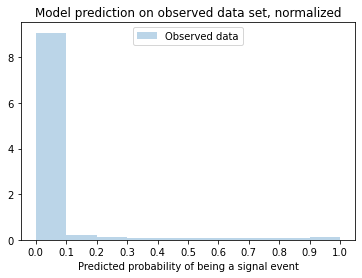

In [14]:
pyplot.hist(model.predict(X_obs), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Observed data')
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'ZTT, ttbar, QCD (MC test set)', histtype = 'step')
#pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'h->aa->bbtautau (MC test set)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on observed data set, normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Write model prediction to root files

## Load all root files one by one

In [16]:
from root_numpy import array2root

paths = ['mt16/DY.root', 'mt16/DY1.root', 'mt16/DY2.root', 'mt16/DY3.root', 'mt16/DY4.root'\
         , 'mt16/GGHTT.root', 'mt16/GGHWW.root', 'mt16/GGZHLLTT.root', 'mt16/GGZHNNTT.root'\
         , 'mt16/GGZHQQTT.root', 'mt16/GGZHWW.root', 'mt16/ST_tW_antitop.root'\
         , 'mt16/ST_tW_top.root', 'mt16/ST_t_antitop.root', 'mt16/ST_t_top.root'\
         , 'mt16/TT.root', 'mt16/VBFHTT.root', 'mt16/VBFHWW.root', 'mt16/VV2L2Nu.root'\
         , 'mt16/W.root', 'mt16/W1.root', 'mt16/W2.root', 'mt16/W3.root', 'mt16/W4.root'\
         , 'mt16/WZ2L2Q.root', 'mt16/WZ3L1Nu.root', 'mt16/WminusHTT.root', 'mt16/WminusHWW.root'\
         , 'mt16/WplusHTT.root', 'mt16/WplusHWW.root', 'mt16/ZHTT.root', 'mt16/ZHWW.root'\
         , 'mt16/ZZ2L2Q.root', 'mt16/ZZ4L.root', 'mt16/data_obs.root', 'mt16/embedded.root'\
         , 'mt16/ggH_bbtt15.root', 'mt16/ggH_bbtt20.root', 'mt16/ggH_bbtt25.root'\
         , 'mt16/ggH_bbtt30.root', 'mt16/ggH_bbtt35.root', 'mt16/ggH_bbtt40.root'\
         , 'mt16/ggH_bbtt45.root', 'mt16/ggH_bbtt50.root', 'mt16/ggH_bbtt55.root'\
         , 'mt16/ggH_bbtt60.root', 'mt16/ttHnonbb.root', 'mt16/vbf_bbtt15.root'\
         , 'mt16/vbf_bbtt20.root', 'mt16/vbf_bbtt25.root', 'mt16/vbf_bbtt30.root'\
         , 'mt16/vbf_bbtt35.root', 'mt16/vbf_bbtt40.root', 'mt16/vbf_bbtt45.root'\
         , 'mt16/vbf_bbtt50.root', 'mt16/vbf_bbtt55.root', 'mt16/vbf_bbtt60.root']

allfiles = []
for i in range(len(paths)):
    allfiles.append(ROOT.RDataFrame('mutau_tree', paths[i]))


for i in range(len(allfiles)):
    allfiles[i] = allfiles[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('dR_tt', dR_tt)\
    .Define('m_bmu', m_bmu)\
    .Define('m_btau', m_btau)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('dR_bmu', dR_bmu)\
    .Define('dR_btau', dR_btau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [17]:
for i in range(len(allfiles)):
    allfiles[i] = pd.DataFrame(allfiles[i].AsNumpy(feature_list))
    allfiles[i] = allfiles[i].values
    allfiles[i] = scaler.transform(allfiles[i])

## Feed to NN and write outputs to root files

In [21]:
for i in range(len(allfiles)):
    y_pred = model.predict(allfiles[i])
    y_pred = np.array(y_pred, dtype = [('pred', np.float32)])
    array2root(y_pred, filename = paths[i], treename = 'mutau_tree', mode = 'update')